In [1]:
from func_utils.plot_utils import show_image
import matplotlib.pyplot as plt 
from glob import glob
import pandas as pd 
import numpy as np 
import json
import os 


import torch 
from torch.utils.data import DataLoader
from func_utils.pydataloader import SynthDogDataset
from encoder_decoder_model import init_dit_bart_models_fixed, add_lora_to_decoder, add_lora_to_encoder_decoder


import evaluate 
from torch.nn.utils.rnn import pad_sequence
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback

import wandb
import gc

torch.cuda.empty_cache()
gc.collect()
wandb.login()

c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: beasted90 (beasted90-comudel) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
# wandb.init(project="ocr model")
decode_to_portuguese = lambda x : x.replace('Ġ','').encode('iso-8859-1').decode('utf-8')

In [3]:
def get_synth_images_json_path(data_root= os.path.join('synthdog','outputs'), split='train'):
    ipath = os.path.join(data_root, '*', split, '*.jpg')
    json_path = os.path.join(data_root, '*', split, 'metadata.jsonl')

    return glob(ipath), glob(json_path)


torch.cuda.empty_cache()

root_path = os.path.join('synthdog', 'outputs_ol')
train_ipath, train_json_metadata = get_synth_images_json_path(data_root=root_path, split='train')
val_ipath, val_json_metadata = get_synth_images_json_path(data_root=root_path, split='validation')
test_ipath, test_json_metadata = get_synth_images_json_path(data_root=root_path, split='test')
processor, text_tokenizer, model = init_dit_bart_models_fixed()
model.gradient_checkpointing_enable()

peak_mem = torch.cuda.max_memory_allocated()
print(f"The model as is is holding: {peak_mem / 1024**3:.2f} of GPU RAM")

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


The model as is is holding: 0.00 of GPU RAM


In [4]:
max_token_size = 512
sample_size = 104
train_synthdataset = SynthDogDataset(train_ipath, train_json_metadata, image_feature_extractor=processor, 
                                     text_tokenizer=text_tokenizer, max_token_size=max_token_size, sample_size=sample_size)
val_synthdataset = SynthDogDataset(val_ipath, val_json_metadata, image_feature_extractor=processor, 
                                   text_tokenizer=text_tokenizer, max_token_size=max_token_size, sample_size=sample_size)
test_synthdataset = SynthDogDataset(test_ipath, test_json_metadata, image_feature_extractor=processor, 
                                    text_tokenizer=text_tokenizer, max_token_size=max_token_size, sample_size=sample_size)

Sampled lang counter: {'en': 52, 'pt': 52}
Length of _.images: 104 | Length of _.json_metadata: 32011
Sampled lang counter: {'en': 52, 'pt': 52}
Length of _.images: 104 | Length of _.json_metadata: 4008
Sampled lang counter: {'pt': 52, 'en': 52}
Length of _.images: 104 | Length of _.json_metadata: 3978


In [ ]:
def improved_collate_fn(batch, text_tokenizer, max_length=512):
    """
    Collate function with padding, truncation, and attention_mask handling.
    """
    pixel_values = []
    labels = []
    attn_masks = []
    
    for item in batch:
        # --- Pixel values ---
        if 'pixel_values' in item:
            pixel_values.append(item['pixel_values'])
        else:
            raise ValueError("Missing 'pixel_values' in batch item")
            
        # --- Labels ---
        if 'labels' in item:
            label = item['labels']
            if len(label.shape) == 0:  # single token
                label = label.unsqueeze(0)
            
            # Truncate if too long
            if label.shape[0] > max_length:
                label = label[:max_length-1]  # leave space for EOS
                eos_tensor = torch.tensor([text_tokenizer.eos_token_id], dtype=torch.long)
                label = torch.cat([label, eos_tensor])
            
            labels.append(label)
        else:
            raise ValueError("Missing 'labels' in batch item")

        # --- Attention masks ---
        if 'attention_mask' in item and item['attention_mask'] is not None:
            attn_mask = item['attention_mask']
            if attn_mask.shape[0] > max_length:
                attn_mask = attn_mask[:max_length]
            attn_masks.append(attn_mask)
        else:
            # if not provided, make a mask of ones
            attn_masks.append(torch.ones_like(label, dtype=torch.long))
    
    # --- Stack pixel values ---
    pixel_values = torch.stack(pixel_values)
    
    # --- Pad labels ---
    labels = pad_sequence(labels, batch_first=True, padding_value=text_tokenizer.pad_token_id)
    
    # --- Pad attention masks ---
    attn_masks = pad_sequence(attn_masks, batch_first=True, padding_value=0)
    
    # --- Replace pad tokens in labels with -100 (ignore index in loss) ---
    labels = labels.clone()
    labels[labels == text_tokenizer.pad_token_id] = -100
    
    return {
        'pixel_values': pixel_values,
        'labels': labels,
        # 'decoder_input_ids': None,
        'decoder_attention_mask': attn_masks
    }


def get_immediate_repetition_ratio(decoded_preds):
    repetitive_count = 0
    for pred in decoded_preds:
        words = pred.split()
        if len(words) > 3:
            # Check for immediate repetitions
            immediate_reps = sum(1 for i in range(len(words)-1) if words[i] == words[i+1])
            if immediate_reps > len(words) * 0.3:  # More than 30% repetition
                repetitive_count += 1
    
    repetitive_ratio = repetitive_count / len(decoded_preds)
    repetitive_ratio

from collections import Counter

def pred_intersect_labels(preds, labels):
    scores = []
    
    for pred, label in zip(preds, labels):
        pred_count = Counter(pred.split())
        label_count = Counter(label.split())
        
        # Multiset intersection (min of counts for each word)
        common = pred_count & label_count
        
        overlap = sum(common.values())
        total = sum(pred_count.values())
        
        score = overlap / total if total > 0 else 0
        scores.append(score)
    
    # Average over all samples
    return sum(scores) / len(scores) if scores else 0

def compute_bleu(decoded_preds, decoded_labels):
    try:
        bleu = evaluate.load("bleu")
        bleu_score = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])
        bleu_value = bleu_score["bleu"]
    except:
        bleu_value = 0.0
    return bleu_value

def compute_metrics_ocr(eval_pred, tokenizer):
    """
    Compute OCR-specific metrics.
    """
    predictions, labels = eval_pred
    
    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Clean up texts
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    
    # Calculate BLEU score
    bleu_value = compute_bleu(decoded_preds, decoded_labels)
    
    # Calculate exact match accuracy
    exact_matches = sum(1 for pred, label in zip(decoded_preds, decoded_labels) if pred == label)
    exact_match_accuracy = exact_matches / len(decoded_preds)
    repetitive_ratio = get_immediate_repetition_ratio(decoded_preds)
    pred_words_in_labels = pred_intersect_labels(decoded_preds, decoded_labels)
    
    
    return {
        "bleu": bleu_value,
        "pred_intersect_labels": pred_words_in_labels
    }

def test_model_before_training(model, image_processor, text_tokenizer, sample_image):
    """
    Test the model with a sample image before training.
    """
    print("Testing model before training...")
    model.eval()
    device = next(model.parameters()).device 
    with torch.no_grad():
        # Process image
        inputs = image_processor(sample_image, return_tensors="pt")
        
        # Generate with the same parameters as model config
        generated_ids = model.generate(
            pixel_values=inputs.pixel_values,
            max_length=model.config.max_length or 512,
            min_length=model.config.min_length or 5,
            num_beams=model.config.num_beams or 3,
            no_repeat_ngram_size=model.config.no_repeat_ngram_size or 2,
            early_stopping=model.config.early_stopping if hasattr(model.config, 'early_stopping') else True,
            pad_token_id=text_tokenizer.pad_token_id,
            eos_token_id=text_tokenizer.eos_token_id,
            repetition_penalty=model.config.repetition_penalty or 1.3,
            length_penalty=model.config.length_penalty or 1.5
        )
        
        generated_text = text_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        print(f"Generated text (before training): '{generated_text}'")
        
        # Check if it's repetitive
        words = generated_text.split()
        if len(words) > 3:
            unique_words = len(set(words))
            repetition_ratio = 1 - (unique_words / len(words))
            print(f"Repetition ratio: {repetition_ratio:.2f}")
            if repetition_ratio > 0.5:
                print("WARNING: High repetition detected!")
            else:
                print("Generation looks good - low repetition!")
        
        return generated_text

In [6]:
# Better training arguments
def setup_dit_bart_training(train_dataset, val_dataset, training_args=None, run_name="model_run", loaded_model=None, callbacks=[]):
    """
    Complete setup for DiT-BART training.
    """
    # Initialize model
    image_processor, text_tokenizer, model = init_dit_bart_models_fixed()
    if loaded_model is not None:
        model = loaded_model
    
    
    # Create collate function
    def collate_fn(batch):
        return improved_collate_fn(batch, text_tokenizer)
    
    # Create compute metrics function
    def compute_metrics(eval_pred):
        return compute_metrics_ocr(eval_pred, text_tokenizer)
    
    # Training arguments
    if training_args is None:
        print('Training args not provided, using defaults.')
        training_args = Seq2SeqTrainingArguments(
            output_dir="./dit_bart_outputs_fixed",
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            gradient_accumulation_steps=4,  # Effective batch size = 16
            learning_rate=1e-5,  # Lower learning rate
            num_train_epochs=5,
            warmup_steps=10,
            logging_steps=5,
            save_steps=50,
            eval_steps=50,
            logging_strategy="steps",
            save_total_limit=3,
            fp16=True,
            max_grad_norm=0.5,
            weight_decay=0.01,
            dataloader_pin_memory=False,
            predict_with_generate=True,
            generation_max_length=512,
            generation_num_beams=3,
            report_to=["wandb"],  
            run_name=run_name,
        )
    
    # Initialize trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collate_fn,
        tokenizer=text_tokenizer,
        compute_metrics=compute_metrics,
        callbacks=callbacks
    )
    
    return trainer, model, image_processor, text_tokenizer

In [7]:
def train_dit_bart(train_dataset, val_dataset, model = None, training_args=None, sample_image=None, save_model = False, save_path = "./dit_bart_final", run_name = 'dit_bart_adam'):
    """
    Main function to train DiT-BART model.
    """
    print("Starting DiT-BART training setup...")
    
    # Setup training
    trainer, model, image_processor, text_tokenizer = setup_dit_bart_training(
        train_dataset, val_dataset, training_args=training_args, loaded_model = model, run_name = run_name
    )
    
    # Test model before training (optional)
    if sample_image is not None:
        test_model_before_training(model, image_processor, text_tokenizer, sample_image)
    
    # Start training
    print("Starting training...")
    history = trainer.train()
    
    # Save the final model
    if save_model:
        trainer.save_model(save_path)
        image_processor.save_pretrained(save_path)
        text_tokenizer.save_pretrained(save_path)
    
    print("Training completed!")
    return trainer, model, image_processor, text_tokenizer, history

In [8]:
import torch.nn as nn


def print_trainable_prams(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"✅ Trainable: {name}")
        else:
            print(f"⛔ Frozen: {name}")

def unfreeze_all_params(model, unfreeze_encoder=True, unfreeze_decoder=True, skip_encoder=False, skip_decoder=False):
    if not skip_encoder:
        for param in model.encoder.parameters():
            param.requires_grad = True if unfreeze_encoder else False
    if not skip_decoder:
        for param in model.decoder.parameters():
            param.requires_grad = True if unfreeze_decoder else False
    return model

def freeze_encoder_unfreeze_decoder(model, 
                                    train_decoder_embeddings=True,
                                    train_decoder_cross_attn=True, 
                                    train_decoder_ff=True, 
                                    train_decoder_self_attn=True, 
                                    train_lm_head=True,
                                    applied_lora=False,
                                    skip_encoder=False,
                                    skip_decoder=False,
                                    verbose=True):
    """
    Freeze the encoder and selectively unfreeze parts of the decoder.
    
    Args:
        model: VisionEncoderDecoderModel
        train_decoder_cross_attn (bool): Unfreeze cross-attention layers
        train_decoder_ff (bool): Unfreeze feedforward layers
        train_decoder_self_attn (bool): Unfreeze self-attention layers
        train_lm_head (bool): Unfreeze LM head (output projection)
    """

    # Freeze all encoder parameters
    model = unfreeze_all_params(model, unfreeze_encoder=False, unfreeze_decoder=False, skip_encoder=skip_encoder, skip_decoder=skip_decoder)

    if train_decoder_embeddings:
        for param in model.decoder.base_model.model.model.decoder.embed_tokens.parameters() if applied_lora else model.decoder.model.decoder.embed_tokens.parameters():
            param.requires_grad = True
        for param in model.decoder.base_model.model.model.decoder.embed_positions.parameters() if applied_lora else model.decoder.model.decoder.embed_positions.parameters():
            param.requires_grad = True

    # Now selectively unfreeze decoder parts
    for layer in model.decoder.base_model.model.model.decoder.layers if applied_lora else model.decoder.model.decoder.layers:
        # Cross-attention
        if train_decoder_cross_attn:
            for param in layer.encoder_attn.parameters():
                param.requires_grad = True

        # Self-attention
        if train_decoder_self_attn:
            for param in layer.self_attn.parameters():
                param.requires_grad = True

        # Feed-forward
        if train_decoder_ff:
            for param in layer.fc1.parameters():
                param.requires_grad = True
            for param in layer.fc2.parameters():
                param.requires_grad = True

    # LM head (final linear projection to vocab)
    if train_lm_head and hasattr(model.decoder, "lm_head"):
        for param in model.decoder.lm_head.parameters():
            param.requires_grad = True

    if verbose:
        print("Encoder frozen. Decoder partially trainable:")
        print_trainable_prams(model)
    return model


In [9]:
def debug_model_inputs(trainer, model):
    sample_batch = next(iter(trainer.get_train_dataloader()))
    print("Sample batch keys:", sample_batch.keys())
    for key, value in sample_batch.items():
        print(f"{key}: {value.shape if hasattr(value, 'shape') else type(value)}")
    
    # Try a forward pass to see what happens
    model.eval()
    model.to('cuda')
    print("Model device:", next(model.parameters()).device)
    with torch.no_grad():
        try:
            outputs = model(**sample_batch)
            print("Forward pass successful!")
        except Exception as e:
            print(f"Forward pass failed: {e}")
    model.train()

V1 - Training all the params 

In [22]:
run_name = "dit_bart_raw_full_model_unfreeze"
wandb.init(project="ocr model", name=run_name)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [23]:
num_epochs = 500
training_args = Seq2SeqTrainingArguments(
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=1,
        learning_rate=5e-5,  
        lr_scheduler_type="linear",
        num_train_epochs=num_epochs,
        warmup_steps=50,  
        logging_steps=5,
        save_steps=50,
        eval_steps=50,
        logging_strategy="steps",
        save_total_limit=3,
        fp16=False,
        max_grad_norm=0.98,  
        weight_decay=0.01,
        
        dataloader_pin_memory=False,
        predict_with_generate=True,
        generation_max_length=512,
        generation_num_beams=8,
        report_to=["wandb"],
        run_name=run_name,
        save_safetensors=False,

        eval_strategy="steps",
        save_strategy="steps",
        metric_for_best_model="eval_loss",
        load_best_model_at_end=True,  
        greater_is_better=False,

        label_smoothing_factor=0.1
        )

In [12]:
trainer, model, image_processor, text_tokenizer = train_dit_bart(
    train_synthdataset, 
    train_synthdataset,
    training_args=training_args
)

Starting DiT-BART training setup...


Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
C:\Users\jaabi\AppData\Local\Temp\ipykernel_15036\3100865530.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 0}.


Starting training...


ValueError: You cannot specify both decoder_input_ids and decoder_inputs_embeds at the same time

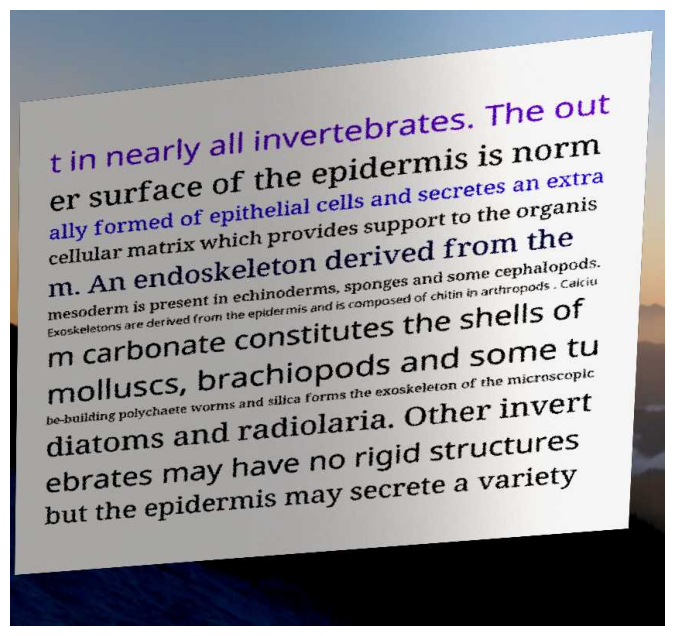

In [15]:
model.eval()
vind = np.random.randint(0, len(val_synthdataset))
sample = val_synthdataset[vind]  # or validation dataset
inputs = sample["pixel_values"].unsqueeze(0).to(model.device)
image = sample['image']
text = sample['text']
show_image(image)

V2. Freezing encoder and some part of decoder

In [14]:
image_processor, text_tokenizer, model = init_dit_bart_models_fixed()
nfmodel = freeze_encoder_unfreeze_decoder(model)

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Encoder frozen. Decoder partially trainable:
⛔ Frozen: encoder.embeddings.cls_token
⛔ Frozen: encoder.embeddings.position_embeddings
⛔ Frozen: encoder.embeddings.patch_embeddings.projection.weight
⛔ Frozen: encoder.embeddings.patch_embeddings.projection.bias
⛔ Frozen: encoder.encoder.layer.0.lambda_1
⛔ Frozen: encoder.encoder.layer.0.lambda_2
⛔ Frozen: encoder.encoder.layer.0.attention.attention.query.weight
⛔ Frozen: encoder.encoder.layer.0.attention.attention.query.bias
⛔ Frozen: encoder.encoder.layer.0.attention.attention.key.weight
⛔ Frozen: encoder.encoder.layer.0.attention.attention.value.weight
⛔ Frozen: encoder.encoder.layer.0.attention.attention.value.bias
⛔ Frozen: encoder.encoder.layer.0.attention.output.dense.weight
⛔ Frozen: encoder.encoder.layer.0.attention.output.dense.bias
⛔ Frozen: encoder.encoder.layer.0.intermediate.dense.weight
⛔ Frozen: encoder.encoder.layer.0.intermediate.dense.bias
⛔ Frozen: encoder.encoder.layer.0.output.dense.weight
⛔ Frozen: encoder.encoder.la

In [ ]:
trainer, model, image_processor, text_tokenizer, history = train_dit_bart(
    train_synthdataset, 
    val_synthdataset,
    epoch=30,
    model=nfmodel
)

Starting DiT-BART training setup...


Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\jaabi\AppData\Local\Temp\ipykernel_28792\2885354249.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 0}.


Starting training...


Step,Training Loss
50,11.117300
100,9.716000
150,8.303400
200,7.799600
250,7.744500
300,7.727400
350,7.736400
400,7.719700
450,7.724700
500,7.709100


c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\transformers\modeling_utils.py:4034: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'min_length': 5, 'early_stopping': True, 'num_beams': 3, 'repetition_penalty': 1.3, 'length_penalty': 1.5, 'no_repeat_ngram_size': 2}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Training completed!


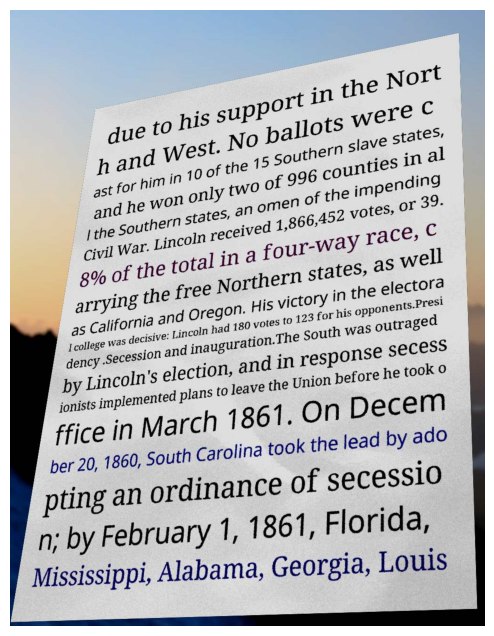

In [45]:
model.eval()
vind = np.random.randint(0, len(val_synthdataset))
sample = val_synthdataset[vind]  # or validation dataset
inputs = sample["pixel_values"].unsqueeze(0).to(model.device)
image = sample['image']
text = sample['text']
show_image(image)

In [47]:
output_ids = model.generate(inputs, max_length=100, num_beams=4)
prediction = text_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Prediction:", prediction)
print("Ground Truth:", sample["text"])

Prediction:  the of., and the the in the to the. the a the is the, the and.. of the- the as the was the by the on the for the with the n the that the The the e the an the " the are the from the t the at the or the's the he the his the o the s thei the be the" the r the were the it the d the which thes theThe thea the not the have the has
Ground Truth: due to his support in the Nort h and West. No ballots were c ast for him in 10 of the 15 Southern slave states, and he won only two of 996 counties in al l the Southern states, an omen of the impending Civil War. Lincoln received 1,866,452 votes, or 39. 8% of the total in a four-way race, c arrying the free Northern states, as well as California and Oregon. His victory in the electora l college was decisive: Lincoln had 180 votes to 123 for his opponents.Presi dency .Secession and inauguration.The South was outraged by Lincoln's election, and in response secess ionists implemented plans to leave the Union before he took o ffice in March 1

V3. Stress testing the model with 4 sample image data to see how it works 

In [ ]:
_, _, ovmodel = init_dit_bart_models_fixed()
ovmodel = freeze_encoder_unfreeze_decoder(model)
ovmodel.gradient_checkpointing_enable()
run_name = "dit_bart_overfit_4_samples try2"
training_args = Seq2SeqTrainingArguments(
            output_dir="./dit_bart_outputs_fixed",
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            gradient_accumulation_steps=1,  
            learning_rate=5e-5,  
            num_train_epochs=200,
            warmup_steps=10,
            logging_steps=5,
            save_steps=50,
            eval_steps=50,
            logging_strategy="steps",
            save_total_limit=3,
            fp16=False,
            max_grad_norm=0.5,
            weight_decay=0.01,
            dataloader_pin_memory=False,
            predict_with_generate=True,
            generation_max_length=512,
            generation_num_beams=3,
            report_to=["wandb"],  
            run_name=run_name,
        )
ovtrainer, ovmodel, ovimage_processor, ovtext_tokenizer, ovhistory = train_dit_bart(
    train_synthdataset, 
    train_synthdataset,
    model=ovmodel,
    training_args=training_args
)

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


Encoder frozen. Decoder partially trainable:
⛔ Frozen: encoder.embeddings.cls_token
⛔ Frozen: encoder.embeddings.position_embeddings
⛔ Frozen: encoder.embeddings.patch_embeddings.projection.weight
⛔ Frozen: encoder.embeddings.patch_embeddings.projection.bias
⛔ Frozen: encoder.encoder.layer.0.lambda_1
⛔ Frozen: encoder.encoder.layer.0.lambda_2
⛔ Frozen: encoder.encoder.layer.0.attention.attention.query.weight
⛔ Frozen: encoder.encoder.layer.0.attention.attention.query.bias
⛔ Frozen: encoder.encoder.layer.0.attention.attention.key.weight
⛔ Frozen: encoder.encoder.layer.0.attention.attention.value.weight
⛔ Frozen: encoder.encoder.layer.0.attention.attention.value.bias
⛔ Frozen: encoder.encoder.layer.0.attention.output.dense.weight
⛔ Frozen: encoder.encoder.layer.0.attention.output.dense.bias
⛔ Frozen: encoder.encoder.layer.0.intermediate.dense.weight
⛔ Frozen: encoder.encoder.layer.0.intermediate.dense.bias
⛔ Frozen: encoder.encoder.layer.0.output.dense.weight
⛔ Frozen: encoder.encoder.la

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
C:\Users\jaabi\AppData\Local\Temp\ipykernel_19432\2866875291.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Starting training...


c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\torch\utils\checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
5,7.779200
10,7.820200
15,7.656900
20,7.634000
25,7.398500
30,7.120100
35,7.054300
40,7.018000
45,7.006600
50,6.730200


c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\torch\utils\checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\torch\utils\checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\torch\utils\checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\torch\utils\checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\torch\utils\checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\torch

Training completed!


In [40]:
ovmodel.eval()
vind = np.random.randint(0, len(train_synthdataset))
sample = train_synthdataset[vind]  
inputs = sample["pixel_values"].unsqueeze(0).to(ovmodel.device)
image = sample['image']
text = sample['text']
output_ids = ovmodel.generate(inputs, max_length=100, num_beams=4)
prediction = text_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Prediction:", prediction)
print("Ground Truth:", sample["text"])

Prediction: . that413
Ground Truth: 413 contained the variable that indicated


V.4 Stress testing the model with Lora instead of manual freezing

In [ ]:
run_name = "dit_bart_overfit_8_samples (lora and new dataset) run 2"
wandb.init(project="ocr model", name=run_name)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▂▁▂▄▆▁▃█▆▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▅▂▂▂▄▁▁▁▁▃▂▁▁▁▁
train/learning_rate,▂▂▃▅▆▇████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
train/loss,███▇███▇▇▇▇▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁
total_flos,2.068036341202944e+17
train/epoch,200
train/global_step,400
train/grad_norm,2.73487
train/learning_rate,0.0
train/loss,7.1719


In [ ]:
_, _, ovmodel = init_dit_bart_models_fixed()
ovmodel = add_lora_to_decoder(ovmodel)
num_epochs = 1000
training_args = Seq2SeqTrainingArguments(
        output_dir="./dit_bart_stress_test_lora",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=1,
        learning_rate=5e-5,  
        num_train_epochs=num_epochs,
        warmup_steps=50,  
        logging_steps=5,
        save_steps=50,
        eval_steps=50,
        logging_strategy="steps",
        save_total_limit=3,
        fp16=False,
        max_grad_norm=1.0,  
        weight_decay=0.01,
        dataloader_pin_memory=False,
        predict_with_generate=True,
        generation_max_length=512,
        generation_num_beams=3,
        report_to=["wandb"],
        run_name=run_name,
        # save_strategy="steps",
        # evaluation_strategy="steps",
        # load_best_model_at_end=True,
        # metric_for_best_model="eval_loss",
        # greater_is_better=False,
        )
ovtrainer, ovmodel, ovimage_processor, ovtext_tokenizer, ovhistory = train_dit_bart(
    train_synthdataset, 
    train_synthdataset,
    model=ovmodel,
    training_args=training_args
)

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


LoRA applied to decoder:
trainable params: 589,824 || all params: 96,693,504 || trainable%: 0.6100
Starting DiT-BART training setup...


Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 960.23it/s]
C:\Users\jaabi\AppData\Local\Temp\ipykernel_27708\2582298397.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 0}.


Starting training...


Step,Training Loss
5,10.746900
10,10.614100
15,10.709600
20,10.619600
25,10.523400
30,10.550100
35,10.307300
40,10.423600
45,10.417700
50,10.094500


c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\transformers\modeling_utils.py:4034: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'min_length': 5, 'early_stopping': True, 'num_beams': 3, 'repetition_penalty': 1.3, 'length_penalty': 1.5, 'no_repeat_ngram_size': 2}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Training completed!


In [25]:
ovmodel.eval()
vind = np.random.randint(0, len(train_synthdataset))
sample = train_synthdataset[vind]  
inputs = sample["pixel_values"].unsqueeze(0).to(ovmodel.device)
image = sample['image']
text = sample['text']
output_ids = ovmodel.generate(inputs, max_length=100, num_beams=4)
prediction = text_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Prediction:", prediction)
print("Ground Truth:", sample["text"])

Prediction:  client; a client cliente clientade client • client a;; client respons clientabil client ( client tr cliento client perpetrator clientos client
Ground Truth: que irá fornecer ao cliente; • Definir a responsabilidade de ambos (planejador e cliente) durante o trabalho;


V5. Freezing the encoder and partially unfreezing few layers in decoder + lora 

In [10]:
# run_name = "dit_bart_overfit_8_samples (lora + enc full freeze and dec par freeze) + attn mask"
run_name = "testing"
wandb.init(project="ocr model", name=run_name)

In [11]:
r=32
alpha=r*2
dropout=0.0
target_modules = [
        "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.out_proj",
        "encoder_attn.q_proj", "encoder_attn.k_proj", "encoder_attn.v_proj", "encoder_attn.out_proj",
        "fc1", "fc2"
]
# modules_to_save = ["embed_tokens", "lm_head"]
modules_to_save = None

num_epochs = 500
training_args = Seq2SeqTrainingArguments(
        output_dir="./dit_bart_stress_test_lora_v5_r3",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=1,
        learning_rate=5e-5,  
        lr_scheduler_type="linear",
        num_train_epochs=num_epochs,
        warmup_steps=50,  
        logging_steps=5,
        save_steps=50,
        eval_steps=50,
        logging_strategy="steps",
        save_total_limit=3,
        fp16=False,
        max_grad_norm=0.98,  
        weight_decay=0.01,
        
        dataloader_pin_memory=False,
        predict_with_generate=True,
        generation_max_length=512,
        generation_num_beams=8,
        report_to=["wandb"],
        run_name=run_name,
        save_safetensors=False,

        eval_strategy="steps",
        save_strategy="steps",
        metric_for_best_model="eval_loss",
        load_best_model_at_end=True,  
        greater_is_better=False,

        # do_predict=True,
        )

In [12]:
_, _, ovmodel = init_dit_bart_models_fixed()
ovmodel = add_lora_to_decoder(ovmodel, r=r, alpha=alpha, dropout=dropout, target_modules=target_modules, modules_to_save=modules_to_save)
ovmodel.config.max_length = 512
ovmodel.config.min_length = 1
ovmodel.config.no_repeat_ngram_size = 3
ovmodel.config.repetition_penalty = 2.5
ovmodel.config.length_penalty = 0.85  
ovmodel.config.early_stopping = True
ovmodel.config.num_beams = 10
# ovmodel.config.temperature = 1.0
# ovmodel.config.top_k = 50
# ovmodel.config.top_p = 0.9

print_trainable_prams(ovmodel)

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


LoRA applied to decoder:
trainable params: 3,833,856 || all params: 99,937,536 || trainable%: 3.8363
✅ Trainable: encoder.embeddings.cls_token
✅ Trainable: encoder.embeddings.position_embeddings
✅ Trainable: encoder.embeddings.patch_embeddings.projection.weight
✅ Trainable: encoder.embeddings.patch_embeddings.projection.bias
✅ Trainable: encoder.encoder.layer.0.lambda_1
✅ Trainable: encoder.encoder.layer.0.lambda_2
✅ Trainable: encoder.encoder.layer.0.attention.attention.query.weight
✅ Trainable: encoder.encoder.layer.0.attention.attention.query.bias
✅ Trainable: encoder.encoder.layer.0.attention.attention.key.weight
✅ Trainable: encoder.encoder.layer.0.attention.attention.value.weight
✅ Trainable: encoder.encoder.layer.0.attention.attention.value.bias
✅ Trainable: encoder.encoder.layer.0.attention.output.dense.weight
✅ Trainable: encoder.encoder.layer.0.attention.output.dense.bias
✅ Trainable: encoder.encoder.layer.0.intermediate.dense.weight
✅ Trainable: encoder.encoder.layer.0.inter

In [13]:
ovmodel = freeze_encoder_unfreeze_decoder(ovmodel, applied_lora=True)

Encoder frozen. Decoder partially trainable:
⛔ Frozen: encoder.embeddings.cls_token
⛔ Frozen: encoder.embeddings.position_embeddings
⛔ Frozen: encoder.embeddings.patch_embeddings.projection.weight
⛔ Frozen: encoder.embeddings.patch_embeddings.projection.bias
⛔ Frozen: encoder.encoder.layer.0.lambda_1
⛔ Frozen: encoder.encoder.layer.0.lambda_2
⛔ Frozen: encoder.encoder.layer.0.attention.attention.query.weight
⛔ Frozen: encoder.encoder.layer.0.attention.attention.query.bias
⛔ Frozen: encoder.encoder.layer.0.attention.attention.key.weight
⛔ Frozen: encoder.encoder.layer.0.attention.attention.value.weight
⛔ Frozen: encoder.encoder.layer.0.attention.attention.value.bias
⛔ Frozen: encoder.encoder.layer.0.attention.output.dense.weight
⛔ Frozen: encoder.encoder.layer.0.attention.output.dense.bias
⛔ Frozen: encoder.encoder.layer.0.intermediate.dense.weight
⛔ Frozen: encoder.encoder.layer.0.intermediate.dense.bias
⛔ Frozen: encoder.encoder.layer.0.output.dense.weight
⛔ Frozen: encoder.encoder.la

In [14]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2, 
)
trainer, model, image_processor, text_tokenizer = setup_dit_bart_training(
        train_synthdataset, train_synthdataset, training_args=training_args, loaded_model = ovmodel, run_name = run_name, callbacks=[early_stopping_callback]
    )

# ovtrainer.add_callback(early_stopping_callback)
# ovtrainer.args.metric_for_best_model="eval_loss"
# ovtrainer.args.greater_is_better=False

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
C:\Users\jaabi\AppData\Local\Temp\ipykernel_7900\3100865530.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [15]:
history = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 0}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss,Bleu,Exact Match,Immediate Repetitive Ratio,Pred Intersect Labels
50,6.912400,6.712807,0.000000,0.000000,None,0.156250
100,4.207500,4.255334,0.000000,0.000000,None,0.061255
150,3.846400,3.878110,0.000000,0.000000,None,0.060362
200,3.608800,3.611556,0.000000,0.000000,None,0.086919
250,3.470100,3.444600,0.000000,0.000000,None,0.091059
300,3.330600,3.294863,0.000000,0.000000,None,0.080521
350,3.227900,3.172560,0.000000,0.000000,None,0.090748
400,3.054800,3.085211,0.000000,0.000000,None,0.091419
450,3.001300,3.019541,0.000000,0.000000,None,0.128806
500,3.072700,2.992226,0.000000,0.000000,None,0.108137


c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\transformers\modeling_utils.py:4034: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'min_length': 1, 'early_stopping': True, 'num_beams': 10, 'repetition_penalty': 2.5, 'length_penalty': 0.85, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [20]:
model.eval()
vind = np.random.randint(0, len(train_synthdataset))
sample = train_synthdataset[vind]  
inputs = sample["pixel_values"].unsqueeze(0).to(model.device)
image = sample['image']
text = sample['text']
output_ids = model.generate(inputs, max_length=100, num_beams=10)
prediction = text_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Prediction:", prediction)
print("Ground Truth:", sample["text"])

Prediction:  point should sol weightanes not determinedids primarily As boiling is alk arethey by the of. it, point point point sol point point weight point point and point point should point pointanes point point not point point determined point pointids point point primarily point point As point point boiling point point is point point alk point point are point pointGeorgia point point a point pointWith point pointthey point point by point pointoo point point the point point heavily point point into point point When point point of point
Ground Truth: they are solids. As the boiling point of alkanes is primarily determined by weight, it should not


v6. full freeze ( encoder ) + full unfreeze ( decoder ) & Lora + attn masking | BEST VERSION SO FAR

In [95]:
max_token_size = 512
sample_size = (8*13) * 2
train_synthdataset = SynthDogDataset(train_ipath, train_json_metadata, image_feature_extractor=processor, 
                                     text_tokenizer=text_tokenizer, max_token_size=max_token_size, sample_size=sample_size)
val_synthdataset = SynthDogDataset(val_ipath, val_json_metadata, image_feature_extractor=processor, 
                                   text_tokenizer=text_tokenizer, max_token_size=max_token_size, sample_size=sample_size)
test_synthdataset = SynthDogDataset(test_ipath, test_json_metadata, image_feature_extractor=processor, 
                                    text_tokenizer=text_tokenizer, max_token_size=max_token_size, sample_size=sample_size)

len(train_synthdataset)

Sampled lang counter: {'en': 104, 'pt': 104}
Length of _.images: 208 | Length of _.json_metadata: 32011
Sampled lang counter: {'en': 104, 'pt': 104}
Length of _.images: 208 | Length of _.json_metadata: 4008
Sampled lang counter: {'pt': 104, 'en': 104}
Length of _.images: 208 | Length of _.json_metadata: 3978


208

In [96]:
run_name = f"dit_bart_overfit_{sample_size}_samples (enc full freeze & dec full unfreeze + lora) + attn mask (balanced dataset)" 
# run_name = "testing"
wandb.init(project="ocr model", name=run_name)

In [101]:
r=32
alpha=r*2
dropout=0.1
target_modules = [
        "q_proj", "k_proj", "v_proj", "out_proj",
        # "fc1", "fc2"
]
# modules_to_save = ["embed_tokens", "lm_head"]
modules_to_save = None

num_epochs = 500
training_args = Seq2SeqTrainingArguments(
        output_dir="./dit_bart_lora_v6",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=4,
        learning_rate=1e-4,  
        lr_scheduler_type="cosine",
        num_train_epochs=num_epochs,
        warmup_ratio=0.1,  
        logging_steps=50,
        save_steps=50,
        eval_steps=50,
        logging_strategy="steps",
        save_total_limit=3,
        fp16=False,
        max_grad_norm=0.99,  
        weight_decay=0.01,
        
        dataloader_pin_memory=False,
        predict_with_generate=True,
        generation_max_length=512,
        generation_num_beams=10,
        report_to=["wandb"],
        run_name=run_name,
        save_safetensors=False,

        eval_strategy="steps",
        save_strategy="steps",
        metric_for_best_model="val_loss",
        load_best_model_at_end=True,  
        greater_is_better=False,

        # label_smoothing_factor=0.1
        )

In [102]:
_, _, ovmodel = init_dit_bart_models_fixed()
ovmodel = add_lora_to_decoder(ovmodel, r=r, alpha=alpha, dropout=dropout, target_modules=target_modules, modules_to_save=modules_to_save)
ovmodel = unfreeze_all_params(ovmodel, unfreeze_encoder=False, unfreeze_decoder=True)
# ovmodel = freeze_encoder_unfreeze_decoder(ovmodel, applied_lora=True)
ovmodel.config.max_length = 512
ovmodel.config.min_length = 1
ovmodel.config.no_repeat_ngram_size = 0
ovmodel.config.repetition_penalty = 2.0
ovmodel.config.length_penalty = 1.0 
ovmodel.config.early_stopping = True
ovmodel.config.num_beams = 6

# print_trainable_prams(ovmodel)

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


LoRA applied to decoder:
trainable params: 2,359,296 || all params: 98,462,976 || trainable%: 2.3961


In [103]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10, 
)
trainer, model, image_processor, text_tokenizer = setup_dit_bart_training(
        train_synthdataset, val_synthdataset, training_args=training_args, loaded_model = ovmodel, run_name = run_name, callbacks=[early_stopping_callback]
    )

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
C:\Users\jaabi\AppData\Local\Temp\ipykernel_1856\3100865530.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [104]:
history = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 0}.


Step,Training Loss,Validation Loss


OverflowError: can't convert negative int to unsigned

In [88]:
wandb.finish()

eval/bleu,▁▁▁▁▁▁▁
eval/exact_match,▁▁▁▁▁▁▁
eval/loss,█▄▁▁▁▂▂
eval/pred_intersect_labels,▁▁▅█▇▆▆
eval/runtime,▁▁▃▃▄▇█
eval/samples_per_second,██▄▄▃▁▁
eval/steps_per_second,██▄▄▃▁▁
train/epoch,▁▁▂▂▃▃▄▄▆▆▇▇███
train/global_step,▁▁▂▂▃▃▅▅▆▆▇▇███
train/grad_norm,▂█▁▁▁▁▁
+2,...


In [94]:
model.eval()
vind = np.random.randint(0, len(train_synthdataset))
sample = train_synthdataset[vind]  
inputs = sample["pixel_values"].unsqueeze(0).to(model.device)
image = sample['image']
text = sample['text']
output_ids = model.generate(inputs, max_length=100, num_beams=10)
prediction = text_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Prediction:", prediction)
print("Ground Truth:", sample["text"])

Prediction: . de,o the aãoaços
Ground Truth: aumenta, em


V7. unfreeze few final layers of encoder + unfeeze all layers of decoder + lora + attention mask

V8. lora encoder + lora decoder + attn masking

In [14]:
run_name = "dit_bart_overfit_8_samples (lora enc + lora dec) + attn mask" 
wandb.init(project="ocr model", name=run_name)

In [ ]:
r=32
alpha=r*2
dropout=0.001
target_modules = [
        "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.out_proj",
        "encoder_attn.q_proj", "encoder_attn.k_proj", "encoder_attn.v_proj", "encoder_attn.out_proj",
        "fc1", "fc2"
]
# modules_to_save = ["embed_tokens", "lm_head"]
modules_to_save = None

num_epochs = 500
training_args = Seq2SeqTrainingArguments(
        output_dir="./dit_bart_stress_test_lora_v5_r3",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=1,
        learning_rate=1e-4,  
        lr_scheduler_type="cosine",
        num_train_epochs=num_epochs,
        warmup_ratio=0.1,  
        logging_steps=50,
        save_steps=50,
        eval_steps=50,
        logging_strategy="steps",
        save_total_limit=3,
        fp16=False,
        max_grad_norm=0.99,  
        weight_decay=0.01,
        
        dataloader_pin_memory=False,
        predict_with_generate=True,
        generation_max_length=512,
        generation_num_beams=10,
        report_to=["wandb"],
        run_name=run_name,
        save_safetensors=False,

        eval_strategy="steps",
        save_strategy="steps",
        metric_for_best_model="eval_loss",
        load_best_model_at_end=True,  
        greater_is_better=False,

        # label_smoothing_factor=0.1
        )

Attention mask alignment

In [19]:
sample = train_synthdataset[0]
pixel_values = sample["pixel_values"].unsqueeze(0).to(model.device)
enc_out = model.encoder(pixel_values = pixel_values, output_hidden_states=True)
enc_out.last_hidden_state.shape

torch.Size([1, 197, 768])

In [28]:
print(enc_out.attentions)

None


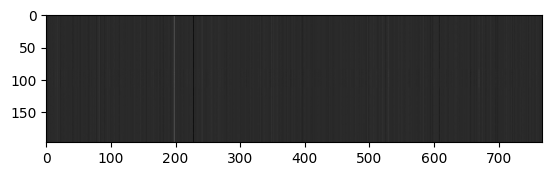

In [26]:
plt.imshow(enc_out.last_hidden_state.squeeze().cpu().numpy(), cmap='gray')

In [62]:
print(text_tokenizer.pad_token_id)
print(text_tokenizer.bos_token_id)
print(text_tokenizer.eos_token_id)
print(text_tokenizer.unk_token_id)
print(text_tokenizer.mask_token_id)

text_tokenizer.mask_token

1
0
2
3
50264


'<mask>'

In [71]:
text_tokenizer.vocab_size

50265

https://arxiv.org/pdf/2205.14100

https://huggingface.co/docs/transformers/model_doc/git